In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy.stats import gaussian_kde
from torchvision.transforms import Compose
from src.datasets.tools.transforms import CloudAngleNormalize
from src.datasets.tools.transforms import Corruption, GlobalShift
from src.datasets.dublin.config import config as dublin_config
import h5py
from tqdm.notebook import tqdm, trange

# for dark-mode
# COLOR = 'white'
# matplotlib.rcParams['text.color'] = COLOR
# matplotlib.rcParams['axes.labelcolor'] = COLOR
# matplotlib.rcParams['xtick.color'] = COLOR
# matplotlib.rcParams['ytick.color'] = COLOR

# more readable font size?
matplotlib.rcParams.update({'font.size': 18})
dataset_path = Path("../dublin/data/150/dataset.h5")
C = Corruption(**dublin_config)
G = GlobalShift(**dublin_config)

In [3]:
# confirm that our files exist, and that the number of examples is in line with
#   our expectations. This also shows the number of source-target pairs. 


with h5py.File(dataset_path, "a") as f:
    example_counts = {}
    for i in trange(0, f['train'].shape[0]):
        src, target = f['train'][i][-1, 8], f['train'][i][0, 8]
        if (src, target) not in example_counts:
            example_counts[(src, target)] = 1
        else:
            example_counts[(src, target)] += 1

totals = []
idx = 0
# some pretty formatting
for key, val in example_counts.items():
    print(f"{key}: {val}", end='  ')
    totals.append(val)
    if idx % 4 == 3:
        print()
    idx+=1
print()

print(f"Mean: {np.mean(totals)}\tStd: {np.std(totals)}")

(26.0, 1.0): 38444  (26.0, 26.0): 39792  (37.0, 1.0): 37250  (37.0, 37.0): 40000  
(21.0, 1.0): 39634  (21.0, 21.0): 39672  (30.0, 1.0): 39656  (30.0, 30.0): 39815  
(22.0, 1.0): 39604  (22.0, 22.0): 39667  (9.0, 1.0): 39616  (9.0, 9.0): 39858  
(10.0, 1.0): 39609  (10.0, 10.0): 39878  (11.0, 1.0): 39395  (11.0, 11.0): 39632  
(4.0, 1.0): 39604  (4.0, 4.0): 39955  (2.0, 1.0): 33005  (2.0, 2.0): 39837  
(40.0, 1.0): 39618  (40.0, 40.0): 39790  (8.0, 1.0): 39501  (8.0, 8.0): 39921  
(16.0, 1.0): 39607  (16.0, 16.0): 39676  (12.0, 1.0): 39600  (12.0, 12.0): 39680  
(35.0, 1.0): 39622  (35.0, 35.0): 39732  (34.0, 1.0): 39607  (34.0, 34.0): 40000  
(20.0, 1.0): 39644  (20.0, 20.0): 39850  (27.0, 1.0): 39612  (27.0, 27.0): 39952  
(7.0, 1.0): 39660  (7.0, 7.0): 39815  (15.0, 1.0): 39618  (15.0, 15.0): 39925  
(0.0, 1.0): 39608  (0.0, 0.0): 40000  (19.0, 1.0): 39444  (19.0, 19.0): 39890  
(6.0, 1.0): 39636  (6.0, 6.0): 40000  (39.0, 1.0): 39608  (39.0, 39.0): 39990  
(32.0, 1.0): 39606  (32.0

In [2]:
x = 10
y = 4
matplotlib.rcParams['figure.figsize'] = [x*1.5, y*1.5]
with h5py.File(dataset_path, "a") as f:
    sample = np.random.choice(f['train'].shape[0], (x, y))

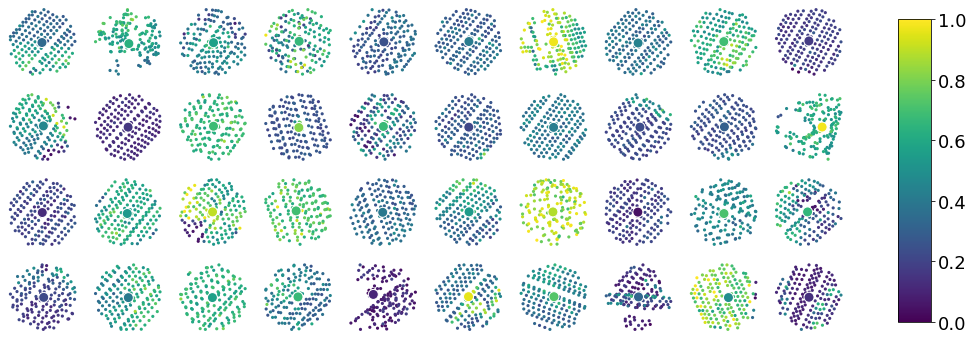

In [19]:
# Visualize Intenties (No transforms)
with h5py.File(dataset_path, "a") as f:
    fig, ax = plt.subplots(y, x)
    for i in range(y):
        for j in range(x):
            example = f['train'][sample[j, i]]
            example = np.flip(example, axis=0)  # reverse so center pt is on top
            # Adjust the gt-center to be more visible
            center = np.ones((example.shape[0])) * 10
            center[-1] = 100
            intensity = example[:, 3]
            e = [[0,0,0,0] for i in range(len(intensity))] # RGBA
            e[-1] = 'w'
            s = ax[i][j].scatter(
                example[:, 0], 
                example[:, 1], 
                s=center, 
                c=example[:, 3], 
                edgecolor=e,
                vmin=0, vmax=1)
            ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()

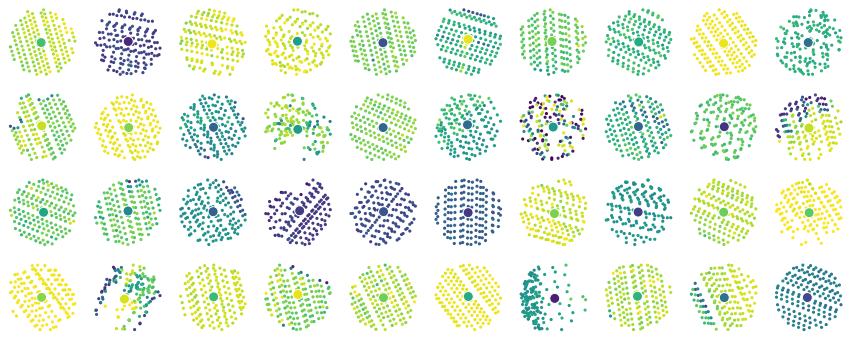

In [3]:
# Visualize Intenties (Corruption)
with h5py.File(dataset_path, "a") as f:
    fig, ax = plt.subplots(y, x)
    for i in range(y):
        for j in range(x):
            example = f['train'][sample[j, i]]
            example = C(example)
            example = np.flip(example, axis=0)  # reverse so center pt is on top
            # Adjust the gt-center to be more visible
            center = np.ones((example.shape[0])) * 10
            center[-1] = 100
            intensity = example[:, 3]
            e = [[0,0,0,0] for i in range(len(intensity))]
            e[-1] = 'w'
            s = ax[i][j].scatter(
                example[:, 0], 
                example[:, 1], 
                s=center, 
                c=example[:, 3], 
                edgecolor=e,
                vmin=0, vmax=1)
            ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
# fig.colorbar(s, cax=cbar_ax)

plt.show()

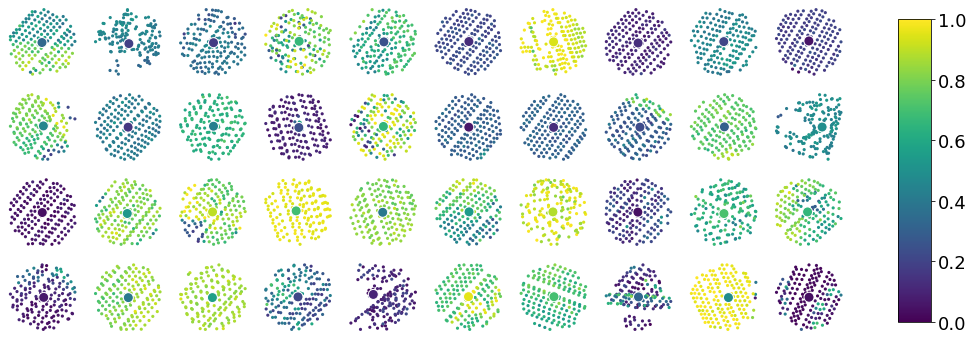

In [21]:
# Visualize Intenties (Global Shift + Corruption)
with h5py.File(dataset_path, "a") as f:
    fig, ax = plt.subplots(y, x)
    for i in range(y):
        for j in range(x):
            example = f['train'][sample[j, i]]
            example = C(G(example))
            example = np.flip(example, axis=0)  # reverse so center pt is on top
            # Adjust the gt-center to be more visible
            center = np.ones((example.shape[0])) * 10
            center[-1] = 100
            intensity = example[:, 3]
            e = [[0,0,0,0] for i in range(len(intensity))]
            e[-1] = 'w'
            s = ax[i][j].scatter(
                example[:, 0], 
                example[:, 1], 
                s=center, 
                c=example[:, 3], 
                edgecolor=e,
                vmin=0, vmax=1)
            ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()